In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('3.csv')

In [3]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['count'] = min_max_scaler.fit_transform(df['count'].values.reshape(-1,1))
    df['Close Price_y'] = min_max_scaler.fit_transform(df['Close Price_y'].values.reshape(-1,1))
    df['edge_count'] = min_max_scaler.fit_transform(df['edge_count'].values.reshape(-1,1))
    df['node_count'] = min_max_scaler.fit_transform(df['node_count'].values.reshape(-1,1))
    df['degree'] = min_max_scaler.fit_transform(df['degree'].values.reshape(-1,1))
    df['log_ret_y'] = min_max_scaler.fit_transform(df['log_ret_y'].values.reshape(-1,1))
    return df

In [4]:
def load_data(stk, seq_len):
    data_raw = stk.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(10/100*data.shape[0]));  
    test_set_size = int(np.round(10/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [5]:
df_norm = normalize_data(df.copy())
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (9946, 19, 6)
y_train.shape =  (9946, 6)
x_valid.shape =  (1243, 19, 6)
y_valid.shape =  (1243, 6)
x_test.shape =  (1243, 19, 6)
y_test.shape =  (1243, 6)


/Users/vsokolov/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 6
n_neurons = 200 
n_outputs = 6
n_layers = 2
learning_rate = 0.001
batch_size = 100
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            mse_test = loss.eval(feed_dict={X: x_test, y: y_test})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
# GridsearchCV not giving any outputs at all , figure out why . 
# implementing denoising autoencoders https://blog.keras.io/building-autoencoders-in-keras.html
# ^ sample code : https://github.com/tgjeon/Keras-Tutorials/blob/master/06_autoencoder.ipynb 


0.00 epochs: MSE train/valid = 0.138426/0.165178
5.00 epochs: MSE train/valid = 0.001075/0.002232
9.99 epochs: MSE train/valid = 0.001102/0.001986
14.99 epochs: MSE train/valid = 0.000999/0.002093
19.99 epochs: MSE train/valid = 0.000993/0.002129


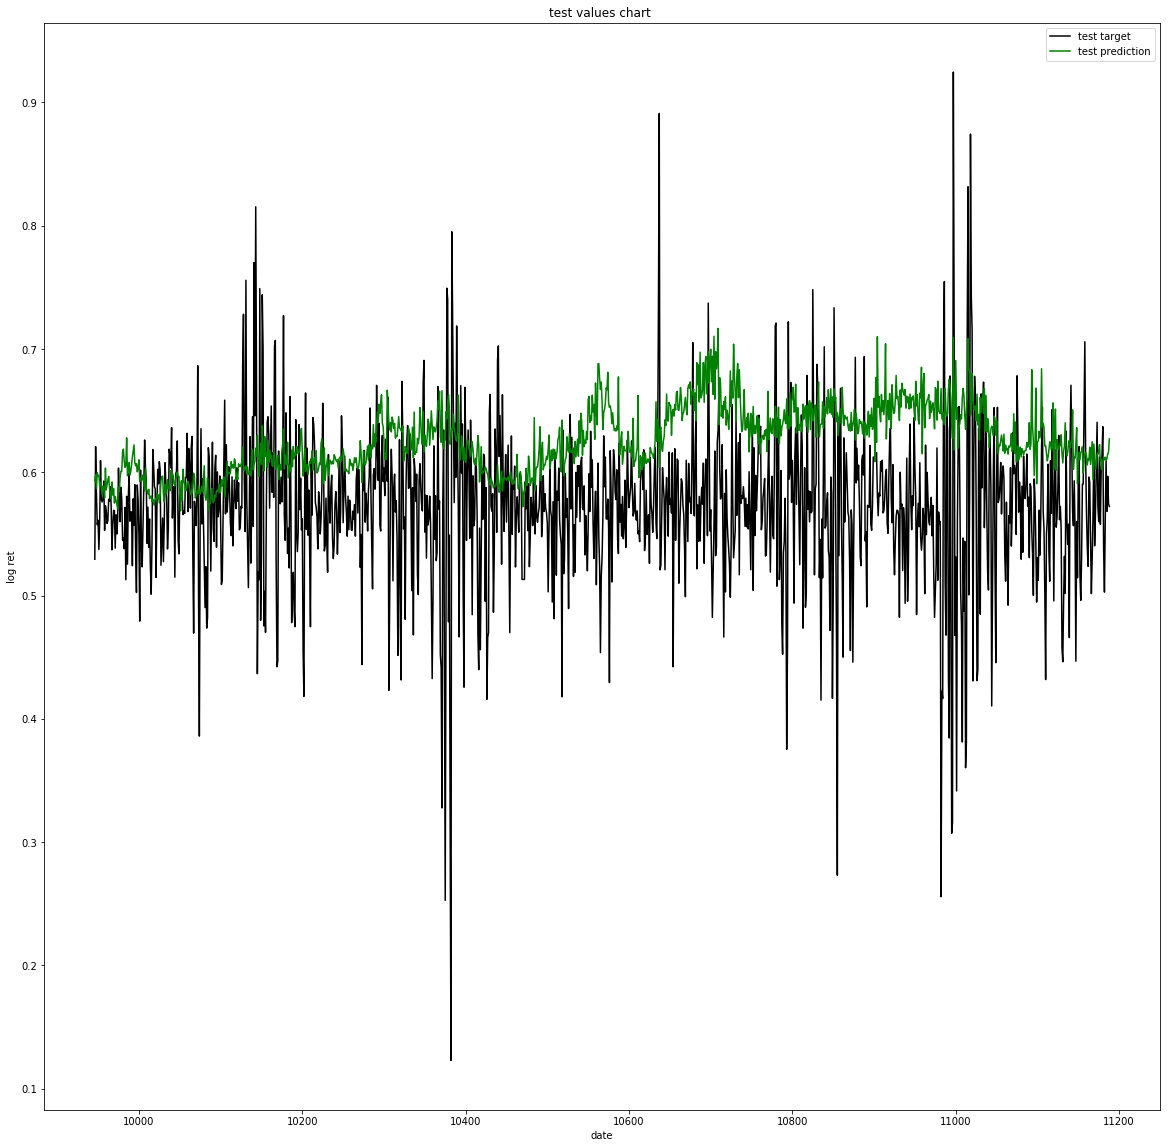

In [13]:

ft = 5

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('test values chart ')
plt.xlabel('date')
plt.ylabel('log ret')
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = [20,20]
plt.show()

In [ ]:
print('mse for training:',mse_train)
print('mse for testing:',mse_test)
print("mse for validation : ",mse_valid)

In [ ]:
# options to consider 
1. Can straight up add adjacency matrices 

In [21]:
np.mean((y_train_pred - y_train)**2)
math.sqrt(np.mean((y_train_pred - y_train)**2))

0.03151404879488084

In [22]:
np.mean(y_train_pred)

0.26968685

In [23]:
np.mean(y_train)

0.27103824656321329